<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter5/5_2_%E5%A4%89%E5%88%86%E8%87%AA%E5%B7%B1%E7%AC%A6%E5%8F%B7%E5%8C%96%E5%99%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install torch==1.10.0
# !pip install pyro-ppl==1.7.0
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO
from pyro.optim import Adam

In [4]:
# 近似分布のパラメータに使用するエンコーダーを設定
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # 線形変換
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # 活性化関数
        self.softplus = nn.Softplus()

    # ガウス分布のパラメータを出力
    def forward(self, x):
        x = x.reshape(-1, 784)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

# モデルの尤度であるデコーダーを設定
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # 線形変換
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # 活性化関数
        self.softplus = nn.Softplus()

    # 画像データの生成
    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        
        # ベルヌーイ分布のパラメータを出力
        loc_img = torch.sigmoid(self.fc21(hidden))
        return loc_img

In [5]:
# VAEクラスを設定
class VAE(nn.Module):
    
    def __init__(self, z_dim=10, hidden_dim=600, use_cuda=False):
        super().__init__()
        # エンコーダーとデコーダーのNNを作成
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # モデルの生成過程を設定
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # zの事前分布の設定
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            # zをサンプリング
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # zからxを生成
            loc_img = self.decoder.forward(z)
            pyro.sample("obs",
                        dist.Bernoulli(loc_img, validate_args=False)
                            .to_event(1),
                        obs=x.reshape(-1, 784))
            return loc_img

    # 近似分布を設定
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # エンコーダーによって近似分布のパラメータを出力
            z_loc, z_scale = self.encoder.forward(x)
            # zを生成
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # 画像データの再構成
    def reconstruct_img(self, x):
        # xをデコーダーに入力して、近似分布のパラメータを出力
        z_loc, z_scale = self.encoder(x)
        # 近似分布からzをサンプリング
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        # zをデコーダーに入力して、xを再構成
        loc_img = self.decoder(z)
        return loc_img

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# 学習用
train_set  = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
# 検証用
test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, shuffle=False)

cuda = True
jit = True
learning_rate = 1.0e-3

# パラメータをリセット
pyro.clear_param_store()

# VAEクラスのインスタンス化
vae = VAE(use_cuda=cuda)

# optimizerの設定
adam_args = {"lr": learning_rate}
optimizer = Adam(adam_args)

# 推論アルゴリズム
elbo = JitTrace_ELBO() if jit else Trace_ELBO()
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
train_elbo = []
#test_elbo = []

num_epochs = 200
for epoch in range(num_epochs):
  epoch_loss = 0.
  for x, _ in train_loader:
      # GPU使用する場合にCUDAメモリにのせる
      if cuda:
          x = x.cuda()
      # Adamによる最適化とロスを加算
      epoch_loss += svi.step(x)
  
      
  # ロスをデータ数で割ってリストに格納
  normalizer_train = len(train_loader.dataset)
  total_epoch_loss_train = epoch_loss / normalizer_train
  train_elbo.append(total_epoch_loss_train)

  print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 174.3751
[epoch 001]  average training loss: 133.9813
[epoch 002]  average training loss: 126.8427
[epoch 003]  average training loss: 122.8945
[epoch 004]  average training loss: 120.3962
[epoch 005]  average training loss: 118.7404
[epoch 006]  average training loss: 117.4862
[epoch 007]  average training loss: 116.4963
[epoch 008]  average training loss: 115.7625
[epoch 009]  average training loss: 115.1201
[epoch 010]  average training loss: 114.5549
[epoch 011]  average training loss: 114.0746
[epoch 012]  average training loss: 113.6554
[epoch 013]  average training loss: 113.2551
[epoch 014]  average training loss: 112.9156
[epoch 015]  average training loss: 112.5185
[epoch 016]  average training loss: 112.2881
[epoch 017]  average training loss: 111.9608
[epoch 018]  average training loss: 111.6758
[epoch 019]  average training loss: 111.3914
[epoch 020]  average training loss: 111.1428
[epoch 021]  average training loss: 110.9158
[epoch 022

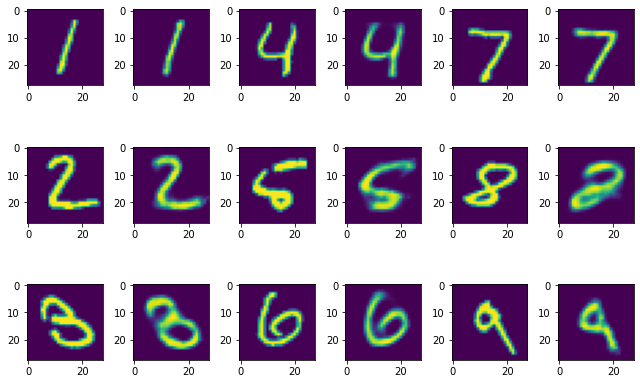

In [8]:
# 隠れ層hを増やすとより復元度合いが高い
need_labels = np.arange(1,10)

fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(9, 6))
for i, (x, y) in enumerate(test_loader):
    if cuda:
        x = x.cuda()
    
    for index in range(x.shape[0]):

      test_img = x[index, :]
      test_label = y[index].item()
      
      if test_label in need_labels:
        # 1~10の画像を一つずつ使用するために可視化したラベルをタブーリストに追加
        need_labels = np.delete(need_labels, np.where(need_labels==test_label)[0])
        
        # 画像を再構成（エンコーダー→デコーダー）
        reco_img = vae.reconstruct_img(test_img)

        # 入力画像と変分自己符号化器で再構築した画像を可視化
        img_2D = test_img.reshape(28, 28).detach().cpu().numpy()
        reco_img_2D = reco_img.reshape(28, 28).detach().cpu().numpy()
        row_idx = test_label%3-1
        col_idx = (test_label-1)//3*2
        ax[row_idx, col_idx].imshow(img_2D)
        ax[row_idx, col_idx+1].imshow(reco_img_2D)
plt.tight_layout();

以下より下の可視化はVAEクラスの隠れ層z_dim=2にして再推論しています。

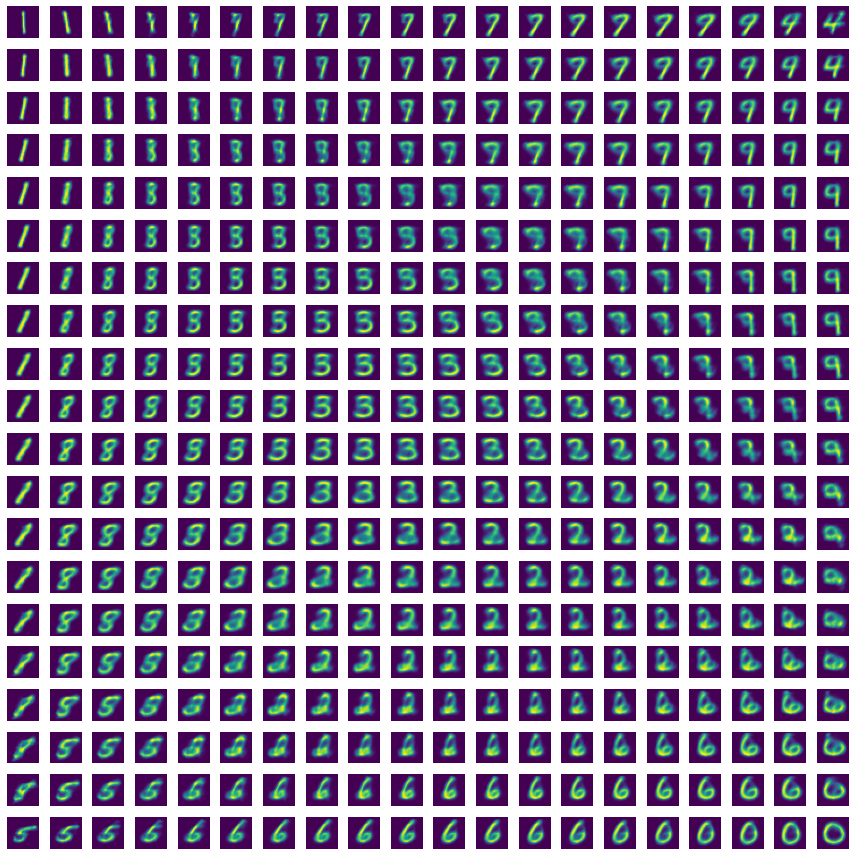

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12), ncols=20, nrows=20)
for idx1,x1 in enumerate(torch.linspace(0.01,0.99,20)):
    for idx2, x2 in enumerate(torch.linspace(0.01, 0.99,20)):
    
      # zをデコーダーに入力して、xを再構成
      z = torch.tensor([x1,x2])
      # 正規分布の累積密度関数の逆関数で変換
      z = torch.distributions.Normal(loc=0.0,scale=1.0).icdf(z)
      if cuda:
          z = z.cuda()
      # 画像の生成
      loc_img = vae.decoder(z)
      
      ax[idx1, idx2].imshow(loc_img.reshape(28, 28).detach().cpu().numpy())
      ax[idx1, idx2].axis('off')
plt.tight_layout();

In [ ]:
%load_ext watermark
%watermark --iversions

matplotlib : 3.2.2
pandas     : 1.3.5
numpy      : 1.21.6
seaborn    : 0.11.2
scipy      : 1.4.1
torch      : 1.11.0+cu113
arviz      : 0.12.1
torchvision: 0.12.0+cu113
pyro       : 1.8.1
IPython    : 5.5.0

